In [3]:
from scipy.io import loadmat
from matplotlib import pyplot as plt
import numpy as np

from mpl_toolkits.mplot3d import Axes3D

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

In [4]:
poses = loadmat('pose.mat')['pose']
poses = poses.transpose([3, 2, 0 ,1]).reshape(68, 13, 48, 40)

TRAIN_POSE_COUNT = 7
TEST_POSE_COUNT = 13 - TRAIN_POSE_COUNT

# Normalize the data as well
# using the first 10 poses of each subject for train
X_train = poses[:, :TRAIN_POSE_COUNT, :, :]/255.

# using the last 3 poses of each subject for test
X_test = poses[:, TRAIN_POSE_COUNT:, :, :]/255.

In [5]:
def combine_images(arr):
    """
    Param: (np.arr) numpy 4D array
    Return: (np.arr) numpy 2D array with images combined 
    """
    
    return arr.reshape(arr.shape[0] * arr.shape[1], arr.shape[2], arr.shape[3])

X_train = combine_images(X_train)
X_test = combine_images(X_test)

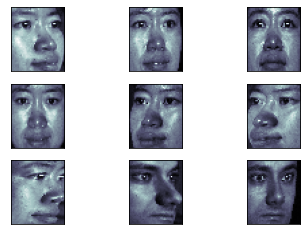

In [6]:
fig, ax = plt.subplots(3,3)

# first 9 images for one subject, each with a diff pose
for i, axis in enumerate(ax.flat):
    axis.imshow(X_train[i], cmap='bone')
    axis.set(xticks=[], yticks=[])

In [7]:
def get_flattened_features(arr): 
    """
    Param: (np.arr) numpy 3D array
    Return: (np.arr) numpy 2D array with flattened features 
    """
    return arr.reshape(arr.shape[0], arr.shape[1] * arr.shape[2])

In [8]:
X_train = get_flattened_features(X_train)
X_test = get_flattened_features(X_test)

In [9]:
X_train.shape, X_test.shape

((476, 1920), (408, 1920))

In [10]:
# sc = StandardScaler()
# sc.fit(X_train)

# X_train = sc.transform(X_train)
# X_test = sc.transform(X_test)

In [11]:
# each subject has 10 images consecutive in the train data 
y_train = np.concatenate([np.ones(TRAIN_POSE_COUNT) * i for i in range(1, X_train.shape[0] // TRAIN_POSE_COUNT + 1)])

# each subject has 3 images consecutive in the test data 
y_test = np.concatenate([np.ones(TEST_POSE_COUNT) * i for i in range(1, X_test.shape[0] // TEST_POSE_COUNT + 1)])

In [12]:
pca = PCA(n_components=65,
          whiten=False,
          random_state=42
        )

pca.fit(X_train)

X_train_reduced = pca.transform(X_train)
X_test_reduced = pca.transform(X_test)

In [13]:
# visualising the reduced dimensions for the pose dataset after applying PCA
def PCA_viz(X, y):
    fig = plt.figure(1, figsize=(8, 6))
    ax = Axes3D(fig, elev=-155, azim=150)
    X_reduced = PCA(n_components=3).fit_transform(X)
    ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=y,
               cmap=plt.cm.Set1, edgecolor='k', s=40)
    ax.set_title("First three PCA directions")
    ax.set_xlabel("1st eigenvector")
    ax.w_xaxis.set_ticklabels([])
    ax.set_ylabel("2nd eigenvector")
    ax.w_yaxis.set_ticklabels([])
    ax.set_zlabel("3rd eigenvector")
    ax.w_zaxis.set_ticklabels([])
    plt.show()
    
# PCA_viz(X_train, y_train)   

### GaussianNB

The naive bayes classifier does best when the PCA's ```n_compenents=16```, changing it only worsens ```nb_test_accuracy```

In [14]:
nb = GaussianNB()
nb.fit(X_train_reduced, y_train)
nb_test_accuracy = nb.score(X_test_reduced, y_test)

nb_test_accuracy

0.7107843137254902

In [15]:
knn_accuracies = []
for i in range(1, 5):
    knn = KNeighborsClassifier(n_neighbors=i, n_jobs=-1)
    knn.fit(X_train_reduced, y_train)
    knn_accuracies.append({
        f"neighbors_{i}": knn.score(X_test_reduced, y_test)
    })

In [16]:
def count(accuracy, total_samples):
    return {
        "accuracy": accuracy,
        "correct": int(np.ceil(total_samples * accuracy)),
        "misclassified": int(np.ceil(total_samples * (1 - accuracy)))
    }

In [17]:
def plot_accuracies(accuracies):
    plt.plot(
        range(1, len(accuracies) + 1),
        [acc[f'neighbors_{i+1}'] for i, acc in enumerate(accuracies)],
    )
    plt.xlabel('neighbors')
    plt.ylabel('accuracy')
    plt.show()

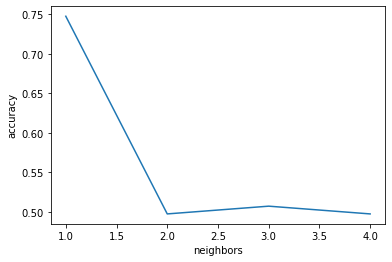

In [18]:
plot_accuracies(knn_accuracies)

In [19]:
percent_accuracies = [acc[f'neighbors_{i+1}'] for i, acc in enumerate(knn_accuracies)]
classfication_count = [count(acc, X_test.shape[0]) for acc in percent_accuracies]
classfication_count

[{'accuracy': 0.7475490196078431, 'correct': 305, 'misclassified': 103},
 {'accuracy': 0.49754901960784315, 'correct': 203, 'misclassified': 205},
 {'accuracy': 0.5073529411764706, 'correct': 207, 'misclassified': 201},
 {'accuracy': 0.49754901960784315, 'correct': 203, 'misclassified': 205}]

### K Nearest Neighbors

As we can see that with higher neighbor the accuracy declines. Also I found that with PCA ```n_components=10``` the accuracy was worse and there was a significant improvment upon increasing it.

### Further processing

The data was not normalized so I normalized it. Also the ```TRAIN_POSE_COUNT``` was very deterministic of the final accuracy. ```TRAIN_POSE_COUNT = 7``` proved to provide the best accuracy with the available data.